### Losses

In [221]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
from torch import nn
from mapsgan import BaseSolver, experiments, data_loader
from mapsgan import ToyGenerator, ToyDiscriminator, BicycleGenerator, norm_scene, cos_scene
from mapsgan.evaluation import Visualization
from sgan import TrajectoryDiscriminator, TrajectoryGenerator
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform, pdist
import os
model_path = '../models/cloud/'
os.listdir(model_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


['bicy_enc_1_20190117-134649_epoch_10000',
 'bicy_weights_1_20190117-155010_epoch_10000',
 'bicy_weights_2_20190118-073226_epoch_70000',
 'clr_1_20190114-160949_epoch_10000',
 'cvae_1_20190114-154818_epoch_10000',
 'sgan_1_20190117-055507_epoch_10000',
 'toymodel_1_20190117-172104_epoch_10000']

#### Init models/ solvers

In [222]:
in_len, out_len = 8, 12

toygenerator = ToyGenerator(in_len=in_len, out_len=out_len)
toydiscriminator = ToyDiscriminator()

bicyclegenerator = BicycleGenerator(ToyGenerator, start_mode='cvae')

sgangenerator = TrajectoryGenerator(obs_len=8,
                                pred_len=12,
                                embedding_dim=16,
                                encoder_h_dim=32,
                                decoder_h_dim=32,
                                mlp_dim=64,
                                num_layers=1,
                                noise_dim=(8,),
                                noise_type='gaussian',
                                noise_mix_type='global',
                                pooling_type='pool_net',
                                pool_every_timestep=1,
                                dropout=0,
                                bottleneck_dim=32,
                                neighborhood_size=2,
                                grid_size=8,
                                batch_norm=0)

In [223]:
solver = BaseSolver(toygenerator, toydiscriminator)

In [224]:
models = {'Baseline':{'generator': toygenerator, 'ckpt': 'toymodel_1_20190117-172104_epoch_10000'},
          'cLRBaseline':{'generator': bicyclegenerator, 'ckpt': 'clr_1_20190114-160949_epoch_10000'},
          'cVAEBaseline':{'generator': bicyclegenerator, 'ckpt': 'cvae_1_20190114-154818_epoch_10000'},
          'BicycleBaseline':{'generator': bicyclegenerator, 'ckpt': 'bicy_weights_2_20190118-073226_epoch_70000'},#'bicy_weights_1_20190117-155010_epoch_10000'},
          'SGAN':{'generator': sgangenerator, 'ckpt': 'sgan_1_20190117-055507_epoch_10000'},
          'cLRSGAN':{'generator': None, 'ckpt': ''},
          'cVAESGAN':{'generator': None, 'ckpt': ''},
          'BicycleSGAN':{'generator': None, 'ckpt': ''}}

In [225]:
experiment = experiments.ETH() # we store filepaths and arguments in here
dataset, trainloader = data_loader(in_len=8,
                                   out_len=12,
                                   batch_size=64,
                                   num_workers=1,
                                   path=experiment.test_dir,
                                   shuffle=False)

### Get losses into right format

In [226]:
losses = {key:{} for key in models}
for model, item in models.items():
    if item['ckpt']:          
        solver.generator = item['generator']
        solver.load_generator(model_path + item['ckpt'])
        if 'Bicycle' in model:
            cvae = solver.train_loss_history['cvae']
            losses[model].update(cvae)
            clr = solver.train_loss_history['clr']['generator']['G_L1']
            losses[model]['generator'].update(G_L1z=clr)
        else:
            losses[model] = solver.train_loss_history
        #print(model, solver.train_loss_history.keys())
losses = {key:value for key,value in losses.items() if value}

In [227]:
oldkey_models = ['cLRBaseline', 'cVAEBaseline', 'SGAN']
keyswitch = {'D_real': 'D_Real', 'D_fake': 'D_Fake', 'G_gan': 'G_BCE', 'G_norm': 'G_L1',
             'G_BCE': 'G_BCE', 'G_L1': 'G_L1', 'G_KL': 'G_KL', 'D_Real':'D_Real', 'D_Fake':'D_Fake',
            'G_total':'G_total', 'D_total':'D_total', 'G_L1z':'G_L1z'}
losses = {key:{} for key in models}
for model, item in models.items():
    if item['ckpt']:          
        solver.generator = item['generator']
        solver.load_generator(model_path + item['ckpt'])
        if 'Bicycle' in model:
            cvae = solver.train_loss_history['cvae']
            losses[model].update(cvae['generator'])
            losses[model].update(cvae['discriminator'])
            clr = solver.train_loss_history['clr']['generator']['G_L1']
            losses[model].update(G_L1z=clr)
        else:
            losses[model].update(solver.train_loss_history['generator'])
            losses[model].update(solver.train_loss_history['discriminator'])
        if model in oldkey_models:
            dict_keys = list(losses[model].keys())
            if model == 'cVAEBaseline':
                losses[model]['G_KL'] = (np.array(losses[model]['G_total']) - np.array(losses[model]['G_gan']) - np.array(losses[model]['G_norm'])).tolist()
            for key in dict_keys:
                losses[model][keyswitch[key]] = losses[model][key]
                del losses[model][key]
                
        #print(model, solver.train_loss_history.keys())
losses = {key:value for key,value in losses.items() if value}
losses['cLRBaseline']['G_L1z'] = losses['cLRBaseline']['G_L1']
del losses['cLRBaseline']['G_L1']

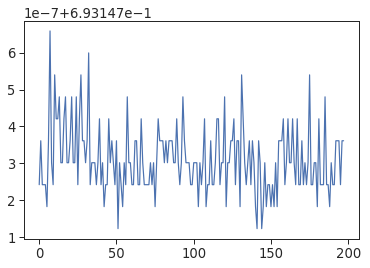

In [135]:
plt.plot(losses['Baseline']['G_BCE'][2:])

[]

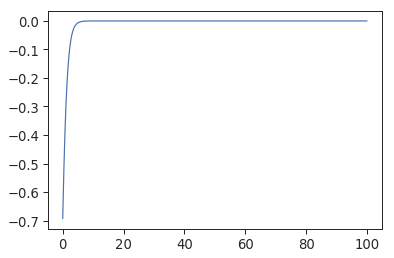

In [140]:
def sigmoid(x):
    return np.log(1/(1+np.exp(-x)))
x = np.arange(0, 100, 0.001)
plt.plot(x, sigmoid(x))
plt.plot()

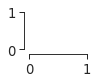

In [40]:
viz = Visualization()
ax = viz.plot.init_subplot(title='', tot_tup=(5, 5), sp_tup=(0, 0))

(0.6931470960378647, 0.6931476861238479)

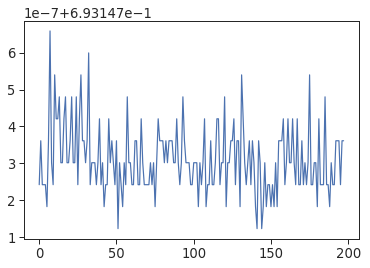

In [190]:
plt.plot(losses['Baseline']['G_BCE'][2:])
ax = plt.gca()
ax.get_ylim()

In [74]:
'geneator' in losses['Baseline'].keys()

False

In [152]:
losses['cLRBaseline']['G_L1z'] = losses['cLRBaseline']['G_L1']

In [155]:
losses['cVAEBaseline'].keys()

dict_keys(['G_BCE', 'G_L1', 'D_Real', 'D_Fake'])

In [228]:
yranges = {(0, 0): [0.3, 1],
             (0, 1): [0.3, 1],
             (0, 2): [0.02, 0.17],
             (0, 3): [-0.2, 1],
             (0, 4): [0.63, 0.83],
           #
             (1, 0): [0.3, 1],
             (1, 1): [0.3, 1],
             (1, 2): [],
             (1, 3): [],
             (1, 4): [0.63, 0.83],
           # 
             (2, 0): [0.3, 1],
             (2, 1): [0.3, 1],
             (2, 2): [0.02, 0.17],
             (2, 3): [-0.2, 1],
             (2, 4): [],
           #
             (3, 0): [0.3, 1],
             (3, 1): [0.3, 1],
             (3, 2): [0.02, 0.17],
             (3, 3): [],
             (3, 4): [],
           #
             (4, 0): [0.3, 1],
             (4, 1): [0.3, 1],
             (4, 2): [0.02, 0.17],
             (4, 3): [],
             (4, 4): []}

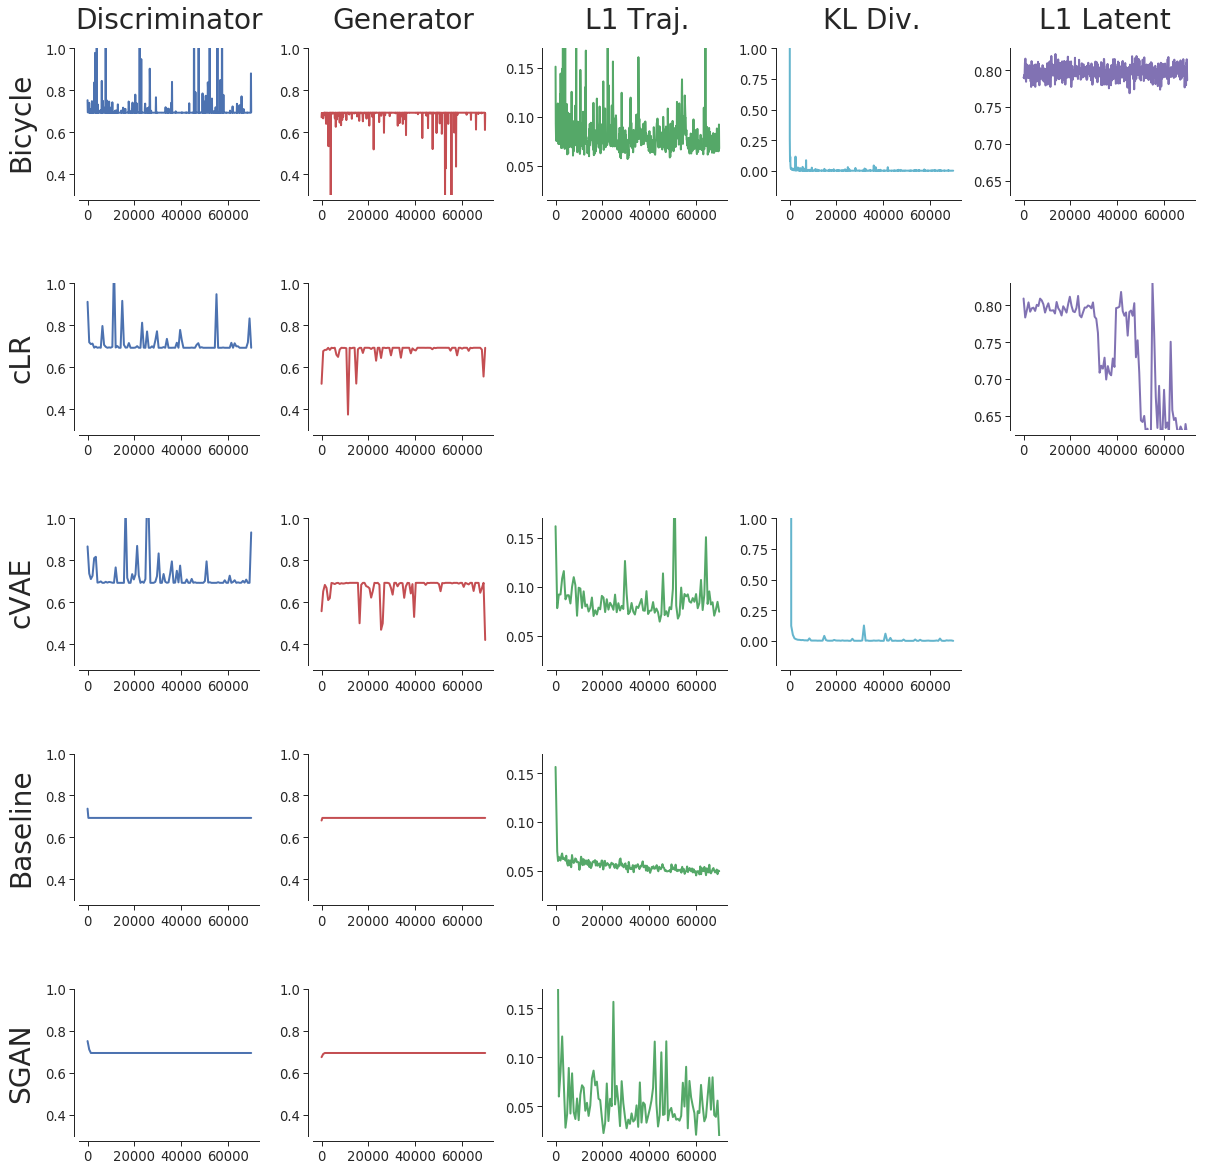

In [230]:
num_rows = len(losses)
order = ['BicycleBaseline', 'cLRBaseline', 'cVAEBaseline', 'Baseline', 'SGAN']
shortnames = {'BicycleBaseline':'Bicycle', 'cLRBaseline':'cLR', 'cVAEBaseline':'cVAE', 'Baseline':'Baseline', 'SGAN':'SGAN'}
loss2plot = ['D_Fake', 'G_BCE', 'G_L1', 'G_KL', 'G_L1z']
losscolor = {'D_Fake':'b', 'G_BCE':'r', 'G_L1':'g', 'G_KL':'c', 'G_L1z':'m'}
pretty_titles = {'D_Fake':'Discriminator', 'G_BCE':'Generator', 'G_L1':'L1 Traj.', 'G_KL':'KL Div.', 'G_L1z':'L1 Latent'}
num_cols = len(loss2plot)
fig = viz.plot.init_figure(figsize=[20, 20], hspace=0.6, wspace=0.3)
for i, model in enumerate(order):
    loss_dict = losses[model]
    for j, loss_key in enumerate(loss2plot):
        if loss_key in loss_dict.keys():
            ax = viz.plot.init_subplot(title='', tot_tup=(num_rows, num_cols), sp_tup=(i, j))
            ax.plot(np.linspace(0, 70000, len(loss_dict[keyswitch[loss_key]])), loss_dict[keyswitch[loss_key]],
                    lw=2, color=losscolor[loss_key])
            if j == 0:
                ax.set_ylabel(shortnames[model], fontsize = 28, labelpad=10)
            if i == 0:
                ax.set_title(pretty_titles[loss_key], fontsize = 28,pad=20)
            ax.set_ylim(yranges[(i,j)])
    

In [131]:
keyswitch['G_L1z']

KeyError: 'G_L1z'

In [103]:
loss_dict.keys(), keyswitch[loss_key]

(dict_keys(['G_gan', 'G_norm', 'G_total', 'D_real', 'D_fake', 'D_total']),
 'D_Fake')

### Scatter plot

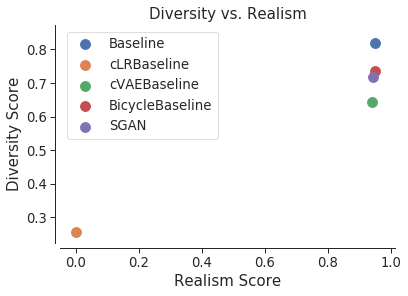

In [20]:
viz = Visualization()
ax = viz.plot.init_subplot(title='Diversity vs. Realism')

for model in cosine_scores:
    ax.scatter(l1_scores[model], cosine_scores[model], s=100, label=model,
               alpha=1)

ax.legend()
ax.set_ylabel('Diversity Score')
ax.set_xlabel('Realism Score')
#ax.grid(True)

plt.show()

### Distance matrix

In [44]:
model='BicycleBaseline'
dataset, trainloader = data_loader(in_len=8,
                                   out_len=12,
                                   batch_size=64,
                                   num_workers=1,
                                   path=experiment.test_dir,
                                   shuffle=True)
generator = models[model]['generator']
solver.generator = generator
ckpt = models[model]['ckpt']
solver.load_generator(model_path + ckpt)
out = solver.test(trainloader)
xy_pred = norm_scene(out['xy_pred'])
xy_out = norm_scene(out['xy_out'])

In [45]:
def dissimilarity_matrix(xy_pred, xy_out):
    max_size = np.max([x.size for x in xy_out]) # number of features (flattend seq dimensions)
    # zero pad and flatten, to put into (obs, feature) matrix
    scenes = np.zeros([len(xy_out), max_size])
    for i, scene in enumerate(xy_out):
        scenes[i, :scene.size] = scene.flatten()
    scenes_pred = np.zeros([len(xy_pred), max_size])
    for i, scene in enumerate(xy_pred):
        scenes_pred[i, :scene.size] = scene.flatten()
    M = np.vstack((scenes, scenes_pred))
    dissimilarity = squareform(pdist(M, metric='cosine'))
    return dissimilarity, pdist(scenes, metric='cosine').sum(), pdist(scenes_pred, metric='cosine').sum()

In [46]:
dm = dissimilarity_matrix(xy_pred, xy_out)

In [48]:
dm[1:]

(875.4802928263807, 807.8928958832445)

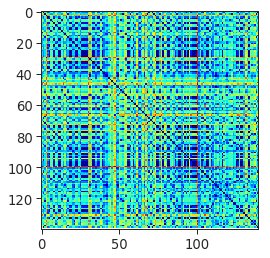

In [47]:
plt.imshow(dm[0], cmap='jet')

### Evaluation metrics

### 1. Diversity
- LPIPs distance? https://arxiv.org/pdf/1801.03924.pdf Measures (weighted) cosine distance of conv features from VGG.
**Lets see cosine distance alone:**

In [36]:
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

##### Evaluate Diversity on whole scenes

In [29]:
max_size = np.max([x.size for x in xy_out]) # number of features (flattend seq dimensions)
# zero pad and flatten, to put into (obs, feature) matrix
scenes = np.zeros([len(xy_out), max_size])
for i, scene in enumerate(xy_out):
    scenes[i, :scene.size] = scene.flatten()
scenes_pred = np.zeros([len(xy_pred), max_size])
for i, scene in enumerate(xy_pred):
    scenes_pred[i, :scene.size] = scene.flatten()

In [47]:
M = np.vstack((scenes, scenes_pred))
dissimilarity = squareform(pdist(M, metric='cosine'))

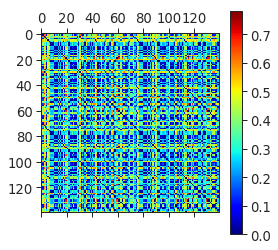

In [49]:
plt.matshow(dissimilarity, cmap = 'jet')
plt.colorbar()

In [58]:
# groundtruth
diver = pdist(scenes, metric='cosine')
# predictions
diver_pred = pdist(scenes_pred, metric='cosine')
print(f'Groundtruth: {diver.sum()}', f'Predictions: {diver_pred.sum()}')

Groundtruth: 708.503486399793 Predictions: 642.898442823863


Conclusion: diversity seems to be evident in these scores, **but** the single trajectories must be normalized since we want to evaluate diversity of the trajectories alone and not of the scenes themselves, since they are mainly conditioned on the initail 8 steps.

#### Norm trajectories

Min-max scaling:
$$\hat{X}=\frac{X-\min_{x}X}{\max_{x}X-\min_{x}X}$$
Reverse:
$$X = ({\max_{x}X-\min_{x}X})\cdot \hat{X}+\min_{x}X$$

In [333]:
def norm_sequence(seq):
    """Normalizes a seq of shape (seq_len, num_agents, num_coords)
    per trajectory.
    """
    seq = np.array(seq)
    eps = 1e-10
    seq = seq.transpose((1, 0, 2))
    normed = np.zeros_like(seq)
    for i, s in enumerate(seq):
        normed[:, i, :] = (s - s.min(axis=0)) / (s.max(axis=0) - s.min(axis=0) + eps)
    return normed

def norm_scene(scene):
    """Normalize all sequences within a scene.
    
    Args:
        scene (list): List of sequences of shape expected by norm_sequence.
    """
    normed = []
    for seq in scene:
        normed.append(norm_sequence(seq))
    return normed

In [15]:
def norm_sequence(seq):
    """Normalizes all trajectories in a sequence independently using
    min-max normalization.

    Args:
        seq (tensor): Tensor of shape (num_agents, num_coords, seq_len)

    Returns:
        tensor: Tensor with normalized coordinates of the same shape as seq.
    """
    eps = 1e-10
    normed = torch.zeros_like(seq)
    seq_min = seq.min(dim=0, keepdim=True)[0].min(dim=2, keepdim=True)[0]
    seq_max = seq.max(dim=0, keepdim=True)[0].max(dim=2, keepdim=True)[0]
    for i, s in enumerate(seq):
        normed[i] = (s - seq_min) / (seq_max - seq_min + eps)
    return normed

In [16]:
norm_sequence(xy_in.permute(1, 2, 0))[0]

NameError: name 'xy_in' is not defined

In [113]:
q = iter(trainloader)

In [114]:
x = next(q)

In [115]:
xy_in = x['xy_in']

In [116]:
seq_start_end = x['seq_start_end']

In [117]:
start, end = seq_start_end[0]

In [122]:
a = xy_in[start:end]

In [143]:
a - a.min(dim=0, keepdim=True)[0].min(dim=0, keepdim=True)[0]

tensor([[[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         ...,
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         ...,
         [0.8600, 0.4900],
         [0.3100, 0.0000],
         [0.5500, 0.0200]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         ...,
         [1.6800, 0.9500],
         [0.9400, 0.1200],
         [1.1700, 0.0300]]])

In [154]:
a - a.min(dim=0, keepdim=True)[0].min(dim=1, keepdim=True)[0]

tensor([[[13.6000,  8.7000],
         [14.6400,  9.1000],
         [19.3300,  3.3400],
         ...,
         [ 4.5100,  0.7900],
         [ 3.1800,  7.0000],
         [ 2.7700,  7.7900]],

        [[13.6000,  8.7000],
         [14.6400,  9.1000],
         [19.3300,  3.3400],
         ...,
         [ 5.3700,  1.2800],
         [ 3.4900,  7.0000],
         [ 3.3200,  7.8100]],

        [[13.6000,  8.7000],
         [14.6400,  9.1000],
         [19.3300,  3.3400],
         ...,
         [ 6.1900,  1.7400],
         [ 4.1200,  7.1200],
         [ 3.9400,  7.8200]]])

In [413]:
eps = 1e-10
seq = dataset.obs_traj
normed = torch.zeros_like(seq)
for i, s in enumerate(seq):
    normed[i] = (s - s.min(dim=0)[0]) / (s.max(dim=0)[0] - s.min(dim=0)[0] + eps)

In [435]:
x = xy_in[0][:, 0, :]

In [438]:
x - x.min(axis=0)

array([[5.0700006 , 0.        ],
       [4.33      , 0.26999998],
       [3.4899998 , 0.37000036],
       [2.7000003 , 0.5300002 ],
       [1.9300003 , 0.6500001 ],
       [1.23      , 0.71000004],
       [0.62000036, 0.8500004 ],
       [0.        , 1.0100002 ]], dtype=float32)

In [423]:
seq[0] - seq[0].min(dim=1, keepdim=True)[0]

tensor([[5.0700, 4.3300, 3.4900, 2.7000, 1.9300, 1.2300, 0.6200, 0.0000],
        [0.0000, 0.2700, 0.3700, 0.5300, 0.6500, 0.7100, 0.8500, 1.0100]])

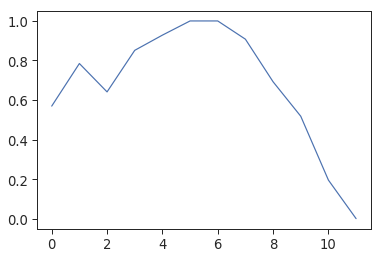

In [400]:
plt.plot(norm_sequence(xy_out[0])[:, 0, 1])

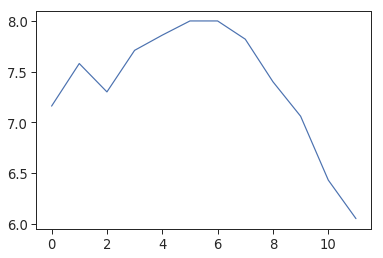

In [401]:
plt.plot(xy_out[0][:, 0, 1])

In [344]:
dataset.obs_traj.permute(2, 0, 1)

torch.Size([8, 181, 2])

In [389]:
torch.zeros_like(x).min(dim = 0)[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
torch.zeros_like(x).min

In [370]:
def displacement(seq):
    disp = torch.zeros_like(seq)
    for i, s in enumerate(seq):
        disp[i, :, 1:] = s[:, 1:] - s[:, :-1]
    return disp

In [365]:
disp = torch.zeros_like(dataset.obs_traj)

In [369]:
disp[0, :, 1:].shape

torch.Size([2, 7])

In [380]:
displacement(dataset.obs_traj), dataset.obs_traj_rel

(tensor([[[ 0.0000, -0.7400, -0.8400,  ..., -0.7000, -0.6100, -0.6200],
          [ 0.0000,  0.2700,  0.1000,  ...,  0.0600,  0.1400,  0.1600]],
 
         [[ 0.0000, -0.5500, -0.9100,  ..., -0.7700, -0.8100, -0.8200],
          [ 0.0000,  0.1700,  0.0700,  ...,  0.0000, -0.0100,  0.0000]],
 
         [[ 0.0000, -0.9700, -0.5800,  ..., -0.3400, -0.6700, -0.8300],
          [ 0.0000, -0.1600, -0.0600,  ..., -0.1200, -0.1000, -0.3300]],
 
         ...,
 
         [[ 0.0000,  0.4600,  0.4600,  ...,  0.4300,  0.4800,  0.4200],
          [ 0.0000, -0.0900,  0.0000,  ..., -0.1000,  0.0300,  0.0000]],
 
         [[ 0.0000,  0.4600,  0.4600,  ...,  0.4900,  0.4600,  0.4300],
          [ 0.0000,  0.0100, -0.0900,  ...,  0.1200,  0.0100,  0.0100]],
 
         [[ 0.0000,  0.4600,  0.4900,  ...,  0.4800,  0.4200,  0.4700],
          [ 0.0000,  0.0000, -0.0600,  ...,  0.0300,  0.0000,  0.0100]]]),
 tensor([[[ 0.0000, -0.7400, -0.8400,  ..., -0.7000, -0.6100, -0.6200],
          [ 0.0000,  0.2700,  

In [349]:
x = dataset.obs_traj[0]

In [357]:
dataset.obs_traj_rel[0]

tensor([[ 0.0000, -0.7400, -0.8400, -0.7900, -0.7700, -0.7000, -0.6100, -0.6200],
        [ 0.0000,  0.2700,  0.1000,  0.1600,  0.1200,  0.0600,  0.1400,  0.1600]])

In [355]:
x

tensor([[10.3100,  9.5700,  8.7300,  7.9400,  7.1700,  6.4700,  5.8600,  5.2400],
        [ 5.9700,  6.2400,  6.3400,  6.5000,  6.6200,  6.6800,  6.8200,  6.9800]])

In [354]:
x[:, 1:] - y[:, :-1]

tensor([[-0.7400, -0.8400, -0.7900, -0.7700, -0.7000, -0.6100, -0.6200],
        [ 0.2700,  0.1000,  0.1600,  0.1200,  0.0600,  0.1400,  0.1600]])

In [382]:
norm_sequence(dataset.obs_traj.permute(2, 0, 1)).shape

(8, 181, 2)

In [102]:
normed_output ={'xy_in': norm_scene(output['xy_in']),
              'xy_out': norm_scene(output['xy_out']),
              'xy_pred': norm_scene(output['xy_pred'])}

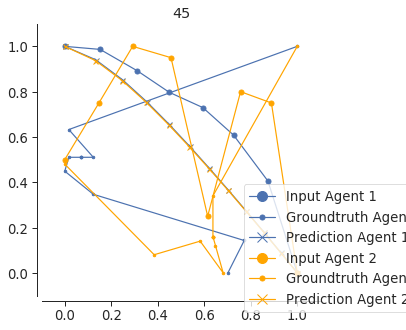

In [113]:
vis.trajectories(normed_output, scenes=[1])

#### Diversity with normed trajectories

In [115]:
xy_out = normed_output['xy_out']
xy_pred = normed_output['xy_pred']
max_size = np.max([x.size for x in xy_out]) # number of features (flattend seq dimensions)
# zero pad and flatten, to put into (obs, feature) matrix
scenes = np.zeros([len(xy_out), max_size])
for i, scene in enumerate(xy_out):
    scenes[i, :scene.size] = scene.flatten()
scenes_pred = np.zeros([len(xy_pred), max_size])
for i, scene in enumerate(xy_pred):
    scenes_pred[i, :scene.size] = scene.flatten()

In [188]:
M = np.vstack((scenes, scenes_pred))
dissimilarity = squareform(pdist(M, metric='cosine'))

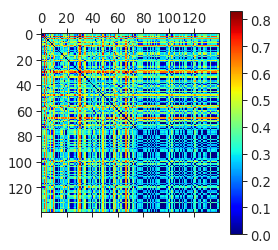

In [189]:
plt.matshow(dissimilarity, cmap = 'jet')
plt.colorbar()

#### Now, we nicely see how the generated output (right bottom square) is less diverse than the groundtruth output.

In [118]:
# groundtruth
diver = pdist(scenes, metric='cosine')
# predictions
diver_pred = pdist(scenes_pred, metric='cosine')
print(f'Groundtruth: {diver.sum()}', f'Predictions: {diver_pred.sum()}')

Groundtruth: 875.4802928263806 Predictions: 461.78947794410806


#### As tensors

In [146]:
cos = nn.CosineSimilarity(dim=0)

In [150]:
1 - cos(torch.Tensor(xy_out[0][:, 0, :]).flatten(), torch.Tensor(xy_out[0][:, 1, :]).flatten())

tensor(0.0221)

In [154]:
torch.Tensor(xy_out[0]).transpose(1, 0).shape

torch.Size([2, 12, 2])

In [43]:
def cos_sequence(seq):
    """Computes the cosine distance of seq of shape (seq_len, num_agents, num_coords)
    per trajectory.
    """
    cos = nn.CosineSimilarity(dim=0)
    eps = 1e-10
    num_agents = seq.shape[1]
    distance = torch.zeros([num_agents, num_agents])
    seq = seq.transpose(1, 0)
    ind = np.triu_indices(num_agents, k=1)
    for i, s1 in enumerate(seq):
        for j, s2 in enumerate(seq):
            distance[i, j] = 1 - cos(s1.flatten(), s2.flatten())
    return distance#[ind]

def cos_scene(scene):
    """Summed cosine distance for all sequences within a scene.
    
    Args:
        scene (list): List of sequences of shape expected by cos_sequence.
    """
    distances = []
    for seq in scene:
        seq = torch.Tensor(seq)
        distances.append(cos_sequence(seq).sum())
    return sum(distances)

In [29]:
a = torch.Tensor(output['xy_pred'][2])

In [46]:
cos_scene(output['xy_pred'])/cos_scene(output['xy_out'])

tensor(0.7904)

In [ ]:
output['xy_pred'][2].transpose

In [316]:
xy_out_T = [torch.Tensor(x) for x in xy_out]

In [317]:
distance_scene(xy_out_T)

tensor(37.0470)

In [321]:
xy_pred_T = [torch.Tensor(x) for x in xy_pred]
distance_scene(xy_pred_T)

tensor(4.9163)

In [322]:
distance_scene(xy_pred_T)/distance_scene(xy_out_T)

tensor(0.1327)

# 2. Realism

### Idea 1: Given an r² value, fit linear splines on trajectories and count the number of knots (or splines) needed for such accurate interpolation. Compare the total number of knots. True trajectories should require more knots than artificial trajectories.

- But, is this a measure for diversity or realism?

In [25]:
from scipy.interpolate import UnivariateSpline

In [245]:
x = xy_out[0][:, 0, 0]
y = xy_out[0][:, 0, 1]

In [246]:
spl = UnivariateSpline(x, y, k=1, s=0.05)

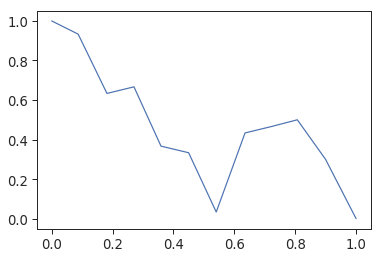

In [260]:
plt.plot(x, y)

In [26]:
def num_knots(seqs):
    num_agents = seqs.shape[1]
    knots = np.zeros(num_agents)
    seqs = seqs.transpose((1, 0, 2))
    for i, seq in enumerate(seqs):
        y = seq[:, 1]
        x = np.linspace(0, 1, y.size)
        spl = UnivariateSpline(x, y, k=1, s=0.05)
        knots[i] = spl.get_knots().size
    return knots

def knots_scene(scene):
    knots = 0
    for seq in scene:
        knots += num_knots(seq).sum()
    return knots

In [31]:
xy_pred = output['xy_pred']
knots_scene(xy_pred)

389.0

### Idea 2: Euclidean distances. Real trajectories should not deviate much from groundtruth trajectories.

In [ ]:
def dist_seq(seqs):
    num_agents = seqs.shape[1]
    distance = np.zeros(num_agents)
    seqs = seqs.transpose((1, 0, 2))
    for i, seq in enumerate(seqs):
        y = seq[:, 1]
        x = np.linspace(0, 1, y.size)
        spl = UnivariateSpline(x, y, k=1, s=0.05)
        knots[i] = spl.get_knots().size
    return knots

def knots_scene(scene):
    knots = 0
    for seq in scene:
        knots += num_knots(seq).sum()
    return knots

In [270]:
mse = nn.MSELoss()

In [276]:
mse(torch.Tensor(xy_out[0]), torch.Tensor(xy_pred[0]))

tensor(0.0186)

# Conclusions: Normalizing the dataset is not feasible so far. Normalizing the predictions before evaluating similarity might make sense tho.
Next steps:
- continue implementing cosine similarity, knots, collisions into evaluation
- implement proper checkpoint/saving as solver.save
- loading as solver.load
- write script to train
- train toymodel on gcloud with real train data